based on https://github.com/uygarkurt/DDPM-Image-Generation/blob/main/DDPM_Image_Generartion.ipynb

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit

In [2]:
RANDOM_SEED = 42
IMG_SIZE = 64
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1
GENERATE_AFTER = 2

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
local_dataset_path = f"data/square{IMG_SIZE}_random0.1/"
dataset = load_dataset('imagefolder', data_dir=local_dataset_path)


Resolving data files:   0%|          | 0/30312 [00:00<?, ?it/s]

In [4]:
dataset = dataset['train']

C:\Users\adamm\AppData\Local\Temp\ipykernel_24180\2340717843.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


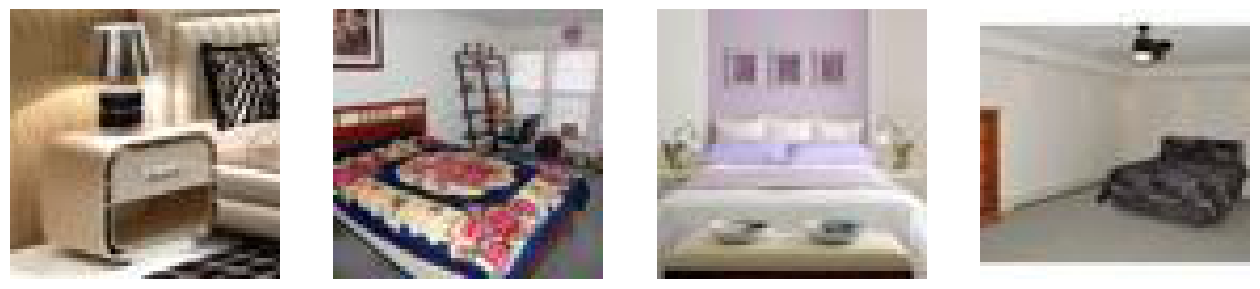

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [6]:
preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [8]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


In [9]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [10]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 64, 64])
Output shape torch.Size([1, 3, 64, 64])


c:\Users\adamm\miniconda3\envs\torchenv\lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


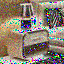

In [11]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [12]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.2127, device='cuda:0', grad_fn=<MseLossBackward0>)


In [13]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

100%|██████████| 1895/1895 [04:07<00:00,  7.65it/s]

------------------------------
Train Loss EPOCH: 1: 0.0698
Train Learning Rate EPOCH: 1: 9.984885930720425e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

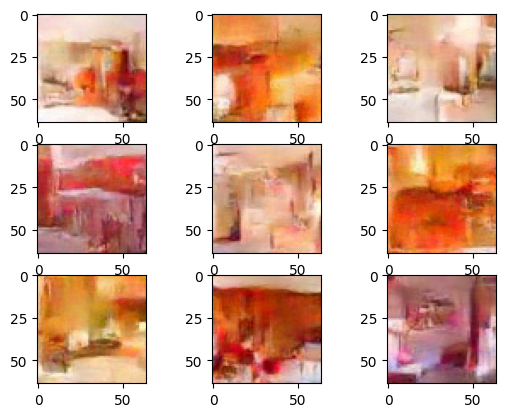

  3%|▎         | 1/30 [04:45<2:18:07, 285.76s/it]

------------------------------


  7%|▋         | 2/30 [08:52<2:02:41, 262.91s/it]

------------------------------
Train Loss EPOCH: 2: 0.0260
Train Learning Rate EPOCH: 2: 9.916126307764644e-05
------------------------------


100%|██████████| 1895/1895 [04:05<00:00,  7.70it/s]

------------------------------
Train Loss EPOCH: 3: 0.0246
Train Learning Rate EPOCH: 3: 9.792545379402821e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

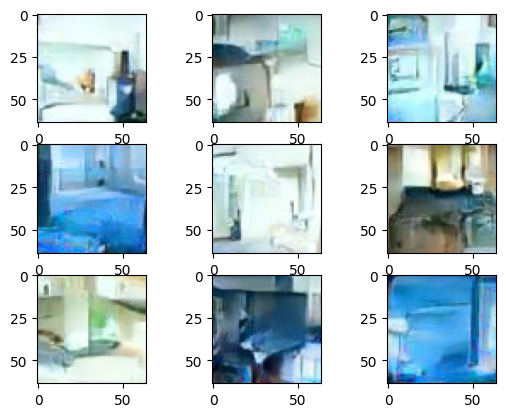

 10%|█         | 3/30 [13:35<2:02:23, 271.99s/it]

------------------------------


 13%|█▎        | 4/30 [17:35<1:52:27, 259.51s/it]

------------------------------
Train Loss EPOCH: 4: 0.0231
Train Learning Rate EPOCH: 4: 9.615521236308784e-05
------------------------------


100%|██████████| 1895/1895 [03:59<00:00,  7.90it/s]

------------------------------
Train Loss EPOCH: 5: 0.0229
Train Learning Rate EPOCH: 5: 9.387027931630326e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

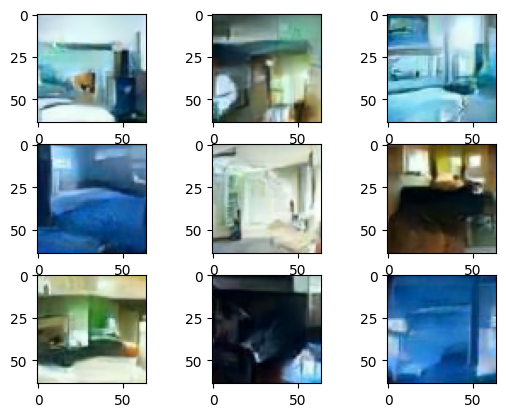

 17%|█▋        | 5/30 [22:12<1:50:44, 265.78s/it]

------------------------------


 20%|██        | 6/30 [26:12<1:42:45, 256.91s/it]

------------------------------
Train Loss EPOCH: 6: 0.0219
Train Learning Rate EPOCH: 6: 9.109613467687738e-05
------------------------------


100%|██████████| 1895/1895 [04:00<00:00,  7.89it/s]

------------------------------
Train Loss EPOCH: 7: 0.0220
Train Learning Rate EPOCH: 7: 8.78655343192512e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

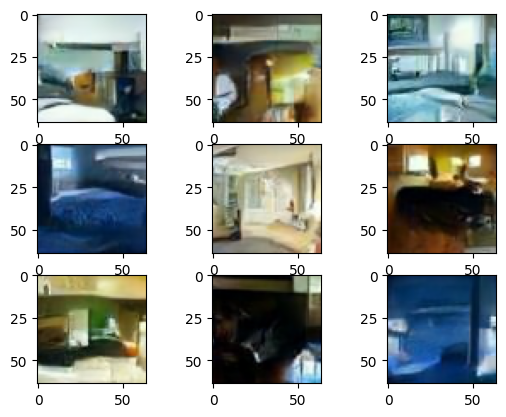

 23%|██▎       | 7/30 [30:49<1:41:00, 263.49s/it]

------------------------------


 27%|██▋       | 8/30 [34:49<1:33:50, 255.92s/it]

------------------------------
Train Loss EPOCH: 8: 0.0212
Train Learning Rate EPOCH: 8: 8.421312832707552e-05
------------------------------


100%|██████████| 1895/1895 [04:00<00:00,  7.89it/s]

------------------------------
Train Loss EPOCH: 9: 0.0213
Train Learning Rate EPOCH: 9: 8.017960291949027e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

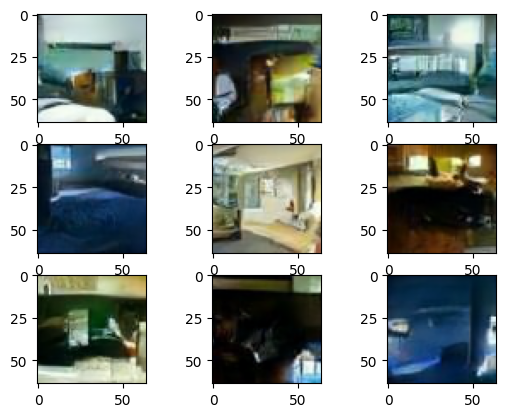

 30%|███       | 9/30 [39:26<1:31:53, 262.55s/it]

------------------------------


 33%|███▎      | 10/30 [43:26<1:25:13, 255.68s/it]

------------------------------
Train Loss EPOCH: 10: 0.0206
Train Learning Rate EPOCH: 10: 7.580988982067693e-05
------------------------------


100%|██████████| 1895/1895 [04:00<00:00,  7.89it/s]

------------------------------
Train Loss EPOCH: 11: 0.0207
Train Learning Rate EPOCH: 11: 7.115266573993277e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

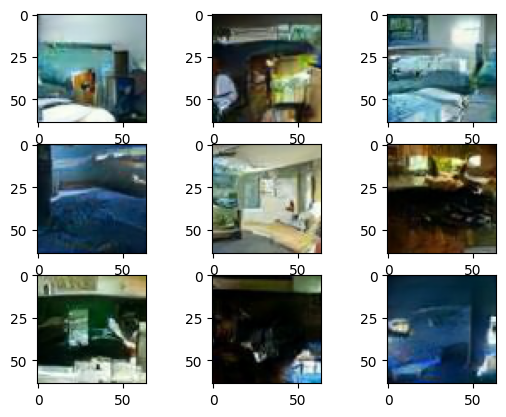

 37%|███▋      | 11/30 [48:03<1:23:03, 262.30s/it]

------------------------------


 40%|████      | 12/30 [52:03<1:16:39, 255.51s/it]

------------------------------
Train Loss EPOCH: 12: 0.0200
Train Learning Rate EPOCH: 12: 6.625981013423456e-05
------------------------------


100%|██████████| 1895/1895 [03:59<00:00,  7.90it/s]

------------------------------
Train Loss EPOCH: 13: 0.0202
Train Learning Rate EPOCH: 13: 6.118582729358176e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

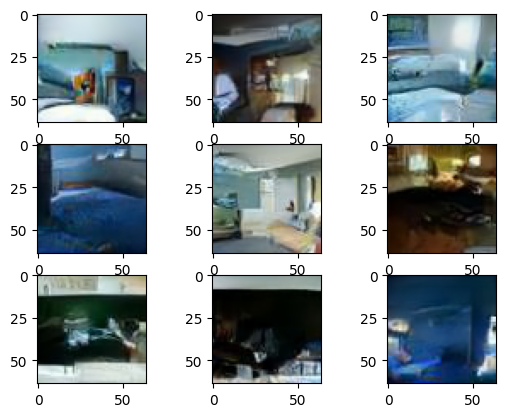

 43%|████▎     | 13/30 [56:40<1:14:13, 261.97s/it]

------------------------------


 47%|████▋     | 14/30 [1:00:46<1:08:34, 257.17s/it]

------------------------------
Train Loss EPOCH: 14: 0.0194
Train Learning Rate EPOCH: 14: 5.598447166380354e-05
------------------------------


100%|██████████| 1895/1895 [04:02<00:00,  7.82it/s]

------------------------------
Train Loss EPOCH: 15: 0.0195
Train Learning Rate EPOCH: 15: 5.071916854986544e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

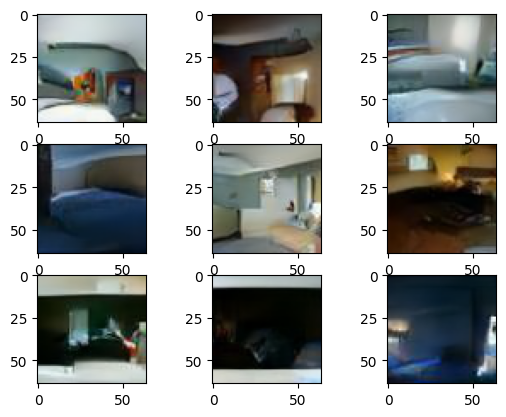

 50%|█████     | 15/30 [1:05:25<1:05:56, 263.79s/it]

------------------------------


 53%|█████▎    | 16/30 [1:09:25<59:52, 256.58s/it]  

------------------------------
Train Loss EPOCH: 16: 0.0188
Train Learning Rate EPOCH: 16: 4.544585421009947e-05
------------------------------


100%|██████████| 1895/1895 [03:58<00:00,  7.93it/s]

------------------------------
Train Loss EPOCH: 17: 0.0189
Train Learning Rate EPOCH: 17: 4.0223271079843046e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

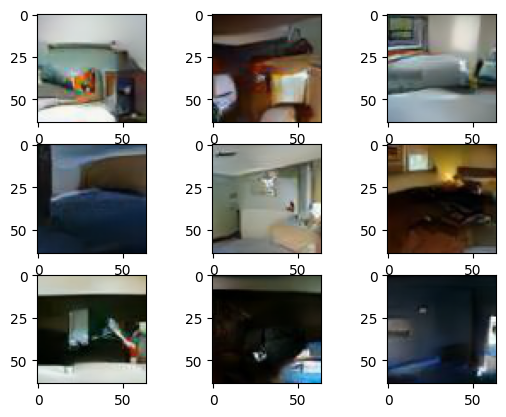

 57%|█████▋    | 17/30 [1:14:01<56:51, 262.39s/it]

------------------------------


 60%|██████    | 18/30 [1:18:00<51:03, 255.33s/it]

------------------------------
Train Loss EPOCH: 18: 0.0181
Train Learning Rate EPOCH: 18: 3.5109596470755626e-05
------------------------------


100%|██████████| 1895/1895 [03:59<00:00,  7.92it/s]

------------------------------
Train Loss EPOCH: 19: 0.0182
Train Learning Rate EPOCH: 19: 3.0159235762647632e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

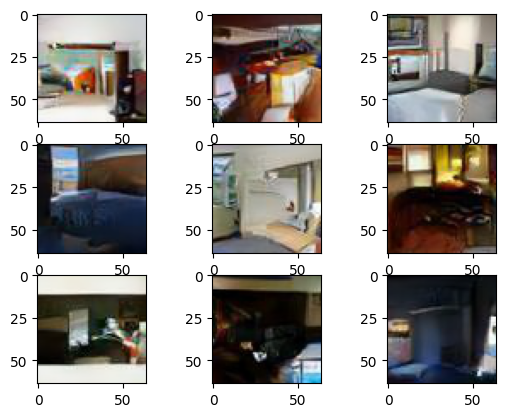

 63%|██████▎   | 19/30 [1:22:36<47:57, 261.63s/it]

------------------------------


 67%|██████▋   | 20/30 [1:26:36<42:29, 254.92s/it]

------------------------------
Train Loss EPOCH: 20: 0.0174
Train Learning Rate EPOCH: 20: 2.543255362964432e-05
------------------------------


100%|██████████| 1895/1895 [03:59<00:00,  7.92it/s]

------------------------------
Train Loss EPOCH: 21: 0.0175
Train Learning Rate EPOCH: 21: 2.0979542197234803e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

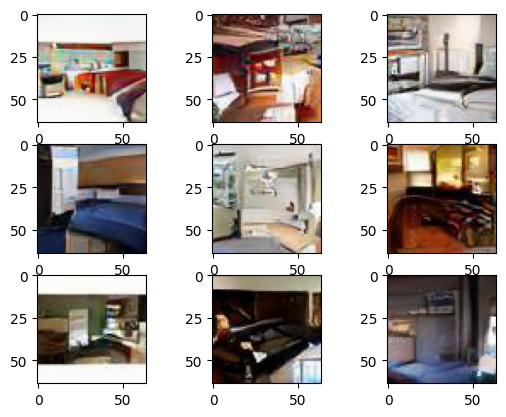

 70%|███████   | 21/30 [1:31:12<39:10, 261.21s/it]

------------------------------


 73%|███████▎  | 22/30 [1:35:11<33:56, 254.54s/it]

------------------------------
Train Loss EPOCH: 22: 0.0168
Train Learning Rate EPOCH: 22: 1.684980608203606e-05
------------------------------


100%|██████████| 1895/1895 [03:59<00:00,  7.90it/s]

------------------------------
Train Loss EPOCH: 23: 0.0169
Train Learning Rate EPOCH: 23: 1.3089348753797332e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

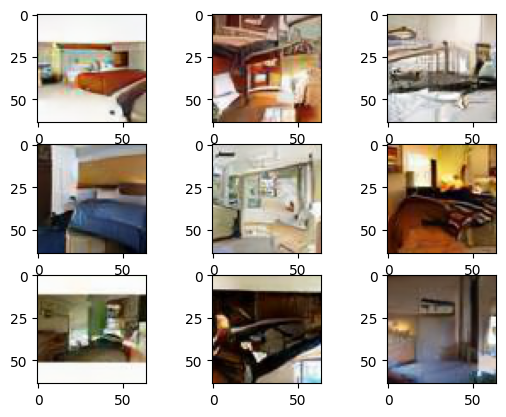

 77%|███████▋  | 23/30 [1:39:47<30:28, 261.20s/it]

------------------------------


 80%|████████  | 24/30 [1:43:47<25:28, 254.71s/it]

------------------------------
Train Loss EPOCH: 24: 0.0163
Train Learning Rate EPOCH: 24: 9.740060076693225e-06
------------------------------


100%|██████████| 1895/1895 [03:59<00:00,  7.91it/s]

------------------------------
Train Loss EPOCH: 25: 0.0165
Train Learning Rate EPOCH: 25: 6.837842473936784e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

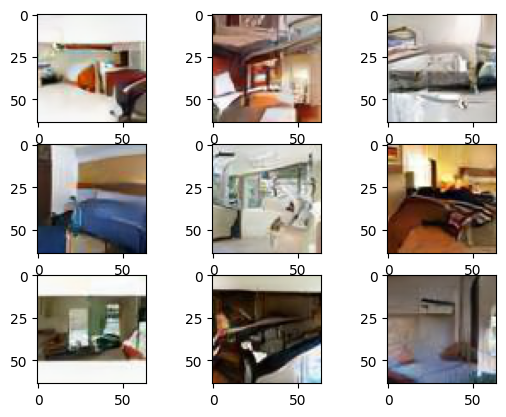

 83%|████████▎ | 25/30 [1:48:23<21:46, 261.28s/it]

------------------------------


 87%|████████▋ | 26/30 [1:52:24<16:59, 254.94s/it]

------------------------------
Train Loss EPOCH: 26: 0.0159
Train Learning Rate EPOCH: 26: 4.418085572700842e-06
------------------------------


100%|██████████| 1895/1895 [03:59<00:00,  7.90it/s]

------------------------------
Train Loss EPOCH: 27: 0.0162
Train Learning Rate EPOCH: 27: 2.5060914347441177e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

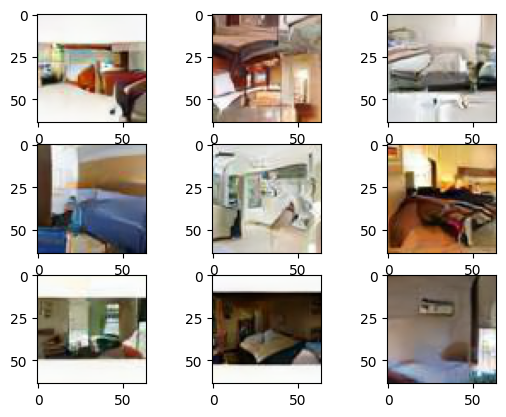

 90%|█████████ | 27/30 [1:57:00<13:04, 261.48s/it]

------------------------------


 93%|█████████▎| 28/30 [2:00:59<08:29, 254.79s/it]

------------------------------
Train Loss EPOCH: 28: 0.0158
Train Learning Rate EPOCH: 28: 1.123158845759581e-06
------------------------------


100%|██████████| 1895/1895 [03:59<00:00,  7.91it/s]

------------------------------
Train Loss EPOCH: 29: 0.0162
Train Learning Rate EPOCH: 29: 2.846930751755572e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

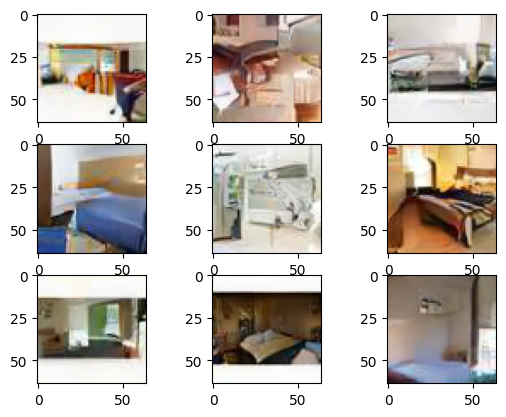

 97%|█████████▋| 29/30 [2:05:36<04:21, 261.25s/it]

------------------------------


100%|██████████| 30/30 [2:09:36<00:00, 259.21s/it]

------------------------------
Train Loss EPOCH: 30: 0.0158
Train Learning Rate EPOCH: 30: 3.108220780201343e-11
------------------------------
Training Time: 7776.07s


In [14]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%GENERATE_AFTER == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/1000 [00:00<?, ?it/s]

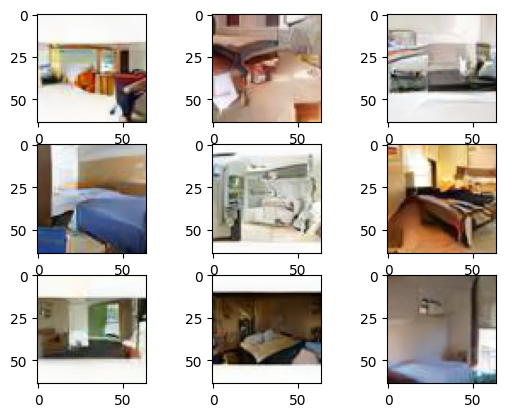

In [15]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
